In [59]:
import sys
sys.path.append('..')

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc

from src.pca import IPCA
from src.rzd import PlacePriceModel

plt.style.use('seaborn-whitegrid')

In [61]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

trains = data[['num', 'class']].drop_duplicates().values.tolist()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

assert (data['weekend'] == 0).all()

data.head(2)

,date,days,places,price,num,class,weekday,day_name,weekend
0,2021-04-06,1,0.623188,3161.0,001А,Купе,1,Tuesday,0
1,2021-04-07,1,0.695652,3275.0,001А,Купе,2,Wednesday,0


## Модель

$$
\begin{cases}
    n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\
    C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau)
\end{cases}
$$

Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [62]:
models = {}
metrics = []

for train_num, train_class in trains:
    train_data = data[(data['num'] == train_num) & (data['class'] == train_class)]
    places = train_data.pivot(index='date', columns='days', values='places')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        
        models[(train_num, train_class)] = model
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
    except Exception as e:
        print(train_num, train_class, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])

metrics.head()

,num,class,explained,r2
0,001А,Купе,0.903176,0.198618
1,001А,СВ,0.538275,0.015410
2,002А,Купе,0.848564,0.114270
3,002А,СВ,0.556895,0.004638
4,003А,Купе,0.618915,0.103327


In [63]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

In [64]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 10)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.85)

sns.heatmap(explained, ax=ax3, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.85)')

sns.heatmap(r2, ax=ax2, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [65]:
metrics.loc[metrics['explained'] <= 0.65, ['num', 'class']]

,num,class
1,001А,СВ
3,002А,СВ
4,003А,Купе
13,701Н,СВ


In [66]:
ncols = 6
nrows = len(models) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for (train_num, train_class), ax in zip(models, axes):
    train_data = data[(data['num'] == train_num) & (data['class'] == train_class)]
    
    for weekday in sorted(train_data['weekday'].unique()):
        weekday_data = train_data[train_data['weekday'] == weekday]
        ax.scatter(
            weekday_data['places'],
            weekday_data['price'],
            marker='.',
            c=f'C{weekday}',
            label=weekdays[weekday],
        )
        
        ox = np.array([weekday_data['places'].min(), weekday_data['places'].max()])
        model = models[(train_num, train_class)]
        b0 = model.regression.b0
        b1 = model.regression.b1
        
        ax.plot(ox, b0 + b1 * ox, lw=1, ls='dashed', c='k', zorder=2)
        
    ax.set_title(f'{train_num}, {train_class}')
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(models), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_price_vs_weekday.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [67]:
a = {}
mean = {}
v = {}

for (train_num, train_class), model in models.items():
    key = f'{train_num}-{train_class}'
    
    if model.explained_variance >= 0.85:
        a[key] = model.a
        mean[key] = model.mean
        v[key] = model.v

a = pd.DataFrame(a)
v = pd.DataFrame(v).T
mean = pd.DataFrame(mean).T

a.reset_index().to_csv('../data/principal_components.csv', index=False)

In [68]:
plt.figure(figsize=(30, 25))

corr = corrcoef(a, reorder=False, alpha=0.01)

sns.heatmap(corr, square=True, cmap='coolwarm', cbar_kws={'aspect': 50})

plt.savefig('../data/figures/pc_corr.pdf', transparent=True, bbox_inches='tight')
plt.close()

_ACF для $a(t)$_

Text(0.5, 0, 'days until departure')

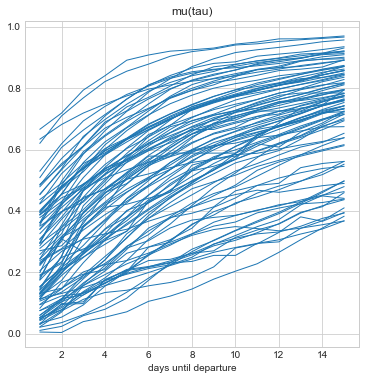

In [69]:
plt.figure(figsize=(6, 6))

for _, row in mean.iterrows():
    plt.plot(row, c='C0', lw=1)

plt.title('mu(tau)')
plt.xlabel('days until departure')

Text(0.5, 0, 'days until departure')

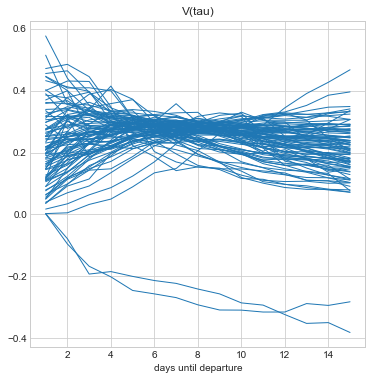

In [70]:
plt.figure(figsize=(6, 6))

for _, row in v.iterrows():
    plt.plot(row, c='C0', lw=1)

plt.title('V(tau)')
plt.xlabel('days until departure')

## Кластеризация по $V(\tau)$

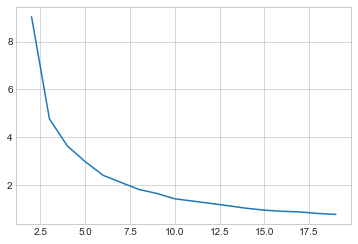

In [44]:
inertia = pd.Series({k: KMeans(k).fit(v.values).inertia_ for k in range(2, 20)})
inertia.plot();

Векторы $V(\tau)$ по разным кластерам.

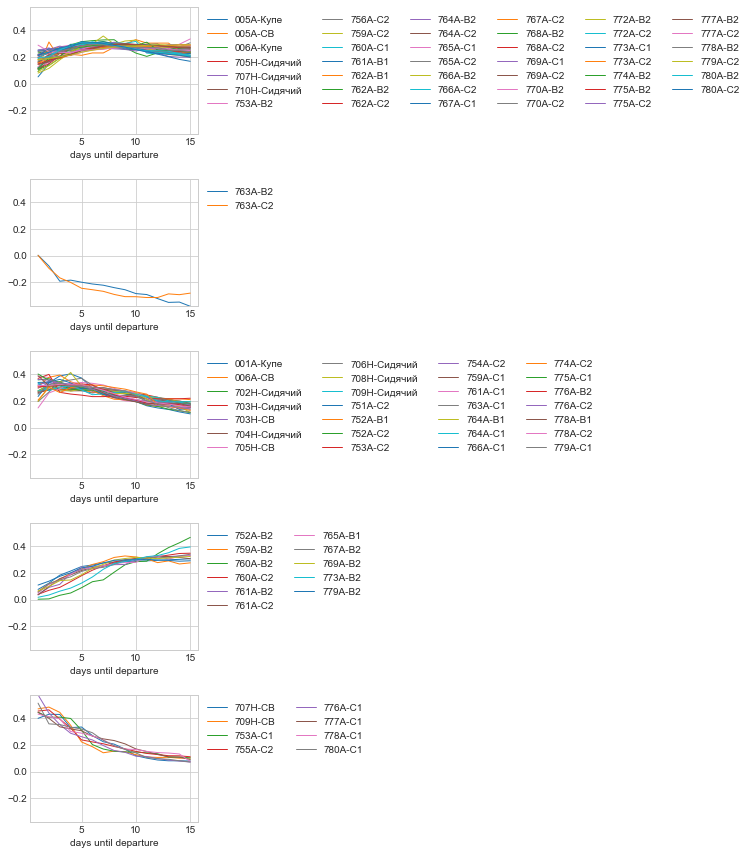

In [71]:
k = 5
kmeans = KMeans(n_clusters=k).fit(v.values)
clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

vmin = v.min().min()
vmax = v.max().max()

for cluster, ax in zip(np.unique(clusters), axes):
    vi = v.loc[clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(vmin, vmax)

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [72]:
cluster_trains = {}

for i in np.unique(clusters):
    trains = v.loc[clusters == i].index.map(lambda s: tuple(s.split('-'))).tolist()
    explained = metrics.set_index(['num', 'class']).loc[trains, 'explained']
    idx = explained.argmax()
    train = explained.index[idx]
    cluster_trains[i] = train
    
cluster_trains = pd.Series(cluster_trains)
cluster_trains

0         (764А, C2)
1         (763А, C2)
2    (709Н, Сидячий)
3         (761А, C2)
4         (709Н, СВ)
dtype: object

In [73]:
dates = data['date'].sort_values().unique()[:15]

cm = LinearSegmentedColormap.from_list('cm', ['C0', 'C2', 'C3'])
colors = cm(np.linspace(0, 1, len(dates)))

dates

array(['2021-04-05T00:00:00.000000000', '2021-04-06T00:00:00.000000000',
       '2021-04-07T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
       '2021-04-09T00:00:00.000000000', '2021-04-10T00:00:00.000000000',
       '2021-04-11T00:00:00.000000000', '2021-04-12T00:00:00.000000000',
       '2021-04-13T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-15T00:00:00.000000000', '2021-04-16T00:00:00.000000000',
       '2021-04-17T00:00:00.000000000', '2021-04-18T00:00:00.000000000',
       '2021-04-19T00:00:00.000000000'], dtype='datetime64[ns]')

Расшифровка моделей для каждого кластера.

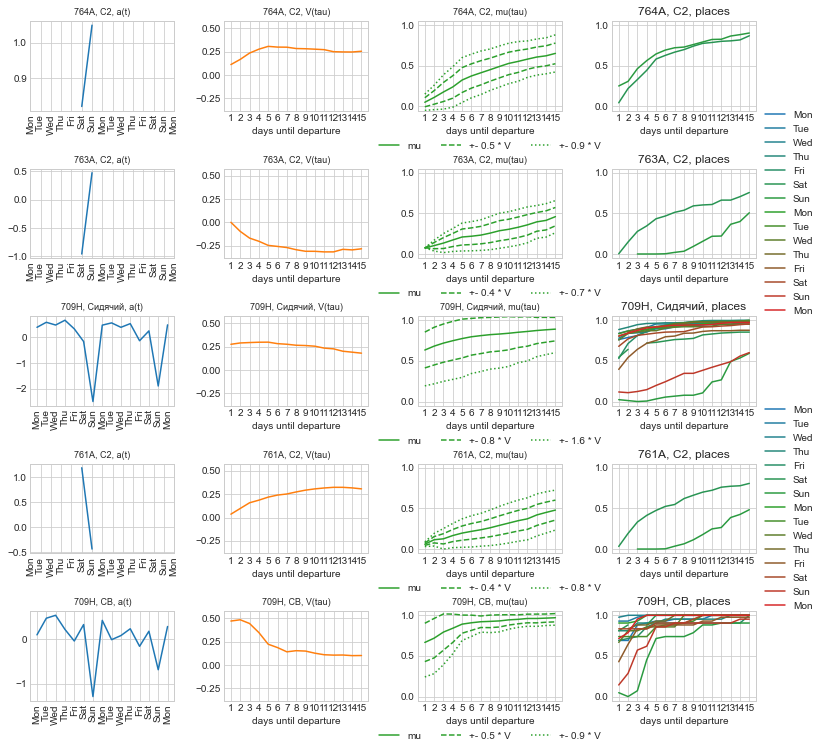

In [74]:
fig, axes = plt.subplots(nrows=len(cluster_trains), ncols=4)
fig.set_size_inches(13, 2.5 * len(cluster_trains))
fig.subplots_adjust(hspace=0.65, wspace=0.35)

linestyles = ['dashed', 'dotted']

for i, (train_num, train_class) in cluster_trains.iteritems():
    model = models[(train_num, train_class)]
    
    ax = axes[i, 0]
    ser = model.a.reindex(dates).copy()
    ax.plot(ser, c='C0', label='a(t)')
    ax.set_xticks(ser.index)
    ax.set_xticklabels(ser.index.day_name().str.slice(0, 3), rotation=90)
    ax.set_title(f'{train_num}, {train_class}, a(t)', fontsize=9)
    
    ax = axes[i, 1]
    model.v.plot(ax=ax, c='C1', label='V(tau)')
    ax.set_xticks(model.v.index)
    ax.set_xticklabels(model.v.index)
    ax.set_title(f'{train_num}, {train_class}, V(tau)', fontsize=9)
    ax.set_xlabel('days until departure')
    ax.set_ylim(vmin, vmax)
    
    ax = axes[i, 2]
    shift = np.abs([ser.min(), ser.max()]).mean()
    shift = np.linspace(0, shift, 3)[1:].round(1)

    model.mean.plot(ax=ax, c='C2', label='mu')
    
    for j, s in enumerate(shift):
        (model.mean + s * model.v).plot(ax=ax, c=f'C2', ls=linestyles[j], label=f'+- {s} * V')
        ax.plot(model.mean - s * model.v, c='C2', ls=linestyles[j])
            
    ax.set_title(f'{train_num}, {train_class}, mu(tau)', fontsize=9)
    ax.set_xlabel('days until departure')
    ax.set_xticks(model.mean.index)
    ax.set_xticklabels(model.mean.index)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=3)
    
    ax = axes[i, 3]
    places = data[(data['num'] == train_num) & (data['class'] == train_class)]\
        .pivot(index='date', columns='days', values='places')\
        .reindex(dates)
    places.index = places.index.day_name().str.slice(0, 3)
    
    for j, c in enumerate(colors):
        row = places.iloc[j]
        row.plot(ax=ax, c=c)
    
    ax.set_title(f'{train_num}, {train_class}, places')
    ax.set_xticks(model.columns)
    ax.set_xticklabels(model.columns)
    ax.set_xlabel('days until departure')
    ax.set_ylim(-0.05, 1.05)

    if i % 2 == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.savefig('../data/figures/eigenvector_cluster_models.pdf', transparent=True, bbox_inches='tight')
# plt.close()

## Корреляции между $a(t)$

In [57]:
# columns = [item[1] for item in sorted(zip(clusters, a.columns))]
corr = truncate_values(a.corr(), th=0.5)

plt.figure(figsize=(20, 18))
sns.heatmap(corr, square=True, cmap='coolwarm', cbar_kws={'aspect': 50})
plt.title('Correlations between A(t)')

plt.savefig('../data/figures/pc_corr.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [27]:
mean_prices = prices.mean(axis=1).groupby(level=[0, 1]).mean()
mean_prices

num   class
002А  Купе      2951.671685
      СВ        6197.704115
004А  Купе      2480.446970
      СВ        5975.805556
006А  Купе      1944.046581
      СВ        4397.113992
752А  B1       15187.284615
      B2        3256.604913
      C1        6455.794709
      C2        2792.031093
754А  B1       15375.253846
      B2        3361.488044
      C1        6857.160684
      C2        2904.037481
756А  B1       16259.113210
      B2        3637.628546
      C1        7549.828205
      C2        3206.222568
760А  B1       17660.994362
      B2        4594.795000
      C1        8934.610000
      C2        4175.007348
768А  B1       16054.615873
      B2        3861.182975
      C1        7752.503687
      C2        3440.797312
770А  B1       15974.549383
      B2        3712.734683
      C1        7500.998976
      C2        3351.590476
772А  B1       15677.891049
      B2        3309.373737
      C1        7609.427778
      C2        2836.890909
774А  B1       15182.255644
      B2